In [1]:
!pip install catboost

# Importação de Bibliotecas

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

# Split Conjunto Treino/Teste

In [3]:
alvo = 'Churn'
df_tot = pd.read_csv('telco-customer-churn-real.zip', dtype = {'SeniorCitizen': str})
df_tot[alvo] = df_tot[alvo].map({'Yes': 1, 'No': 0})
df_tot.loc[df_tot['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_tot['TotalCharges'] = df_tot['TotalCharges'].astype(float)

In [4]:
df_teste = df_tot.sample(frac = 0.5, random_state = 42)
df = df_tot[~df_tot.index.isin(df_teste.index)]

In [5]:
display(display(df_tot[['Partner', alvo]].groupby('Partner').agg(['count', 'mean'])))

Churn          
        count      mean
Partner                
No       1831  0.320590
Yes      1690  0.198817

None

# Tratamento de Features

In [6]:
colunas_id = ['customerID']
features_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
features_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
dict_dummies = {'Partner': ['No']}
for f in [v for v in features_categoricas if v != 'Partner']:
    lista_dummies = list(df[f].value_counts().index[:-1])
    dict_dummies[f] = lista_dummies

for k,v in dict_dummies.items():
    for value in v:
        df[k + '_' + value] = (df[k] == value).astype(int)
        df_teste[k + '_' + value] = (df_teste[k] == value).astype(int)
    df.drop(k, axis = 1, inplace = True)
    df_teste.drop(k, axis = 1, inplace = True)
df.columns = [c.replace(' ', '_') for c in df.columns]
df_teste.columns = [c.replace(' ', '_') for c in df_teste.columns]

In [8]:
features = [v for v in df.columns if v not in colunas_id and v != alvo]

# Treinamento do Modelo

In [9]:
treinar_catboost = True
usar_teste_treinamento = False #Simula vazamento de informação

In [10]:
#Simula treinar com uma amostra da base
df_train = df.sample(frac = 1.0, random_state = 42)

In [11]:
X = df_train[features]
y = df_train[alvo].astype(int)

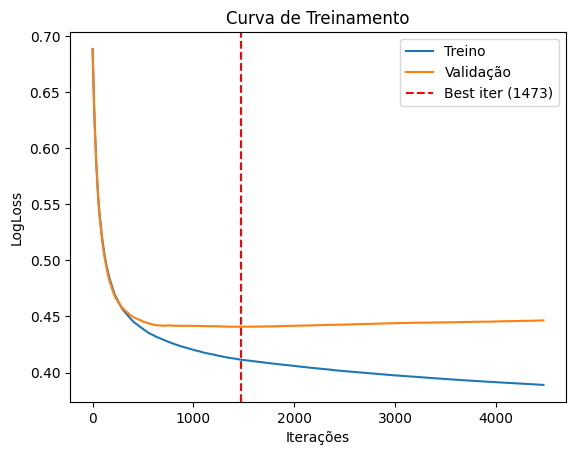

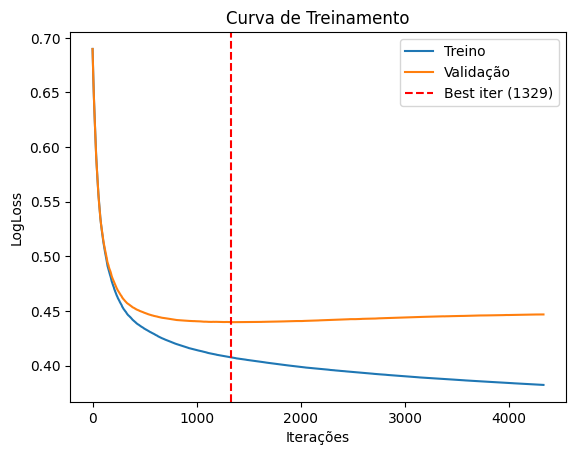

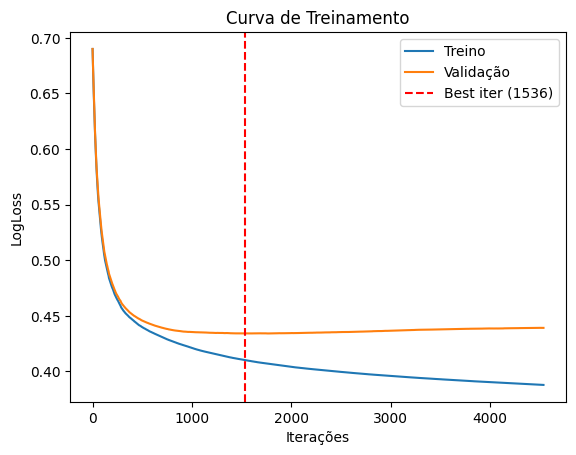

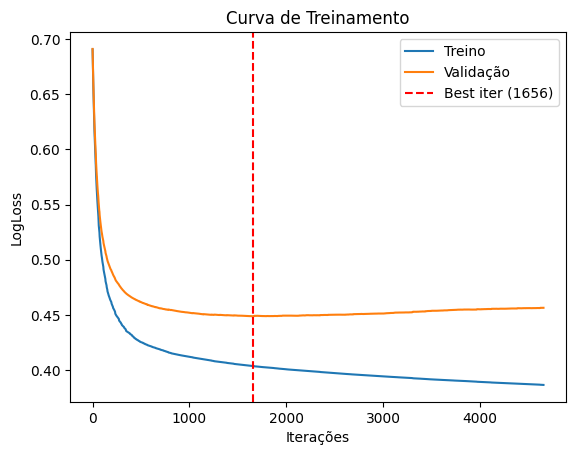

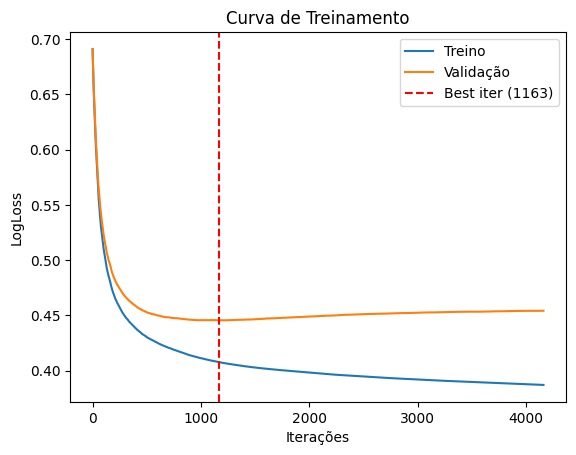

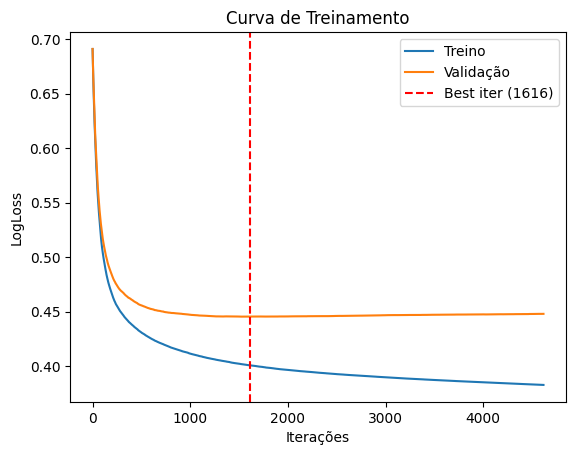

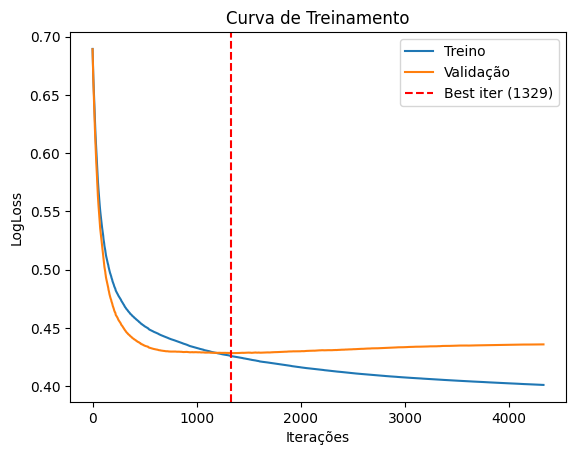

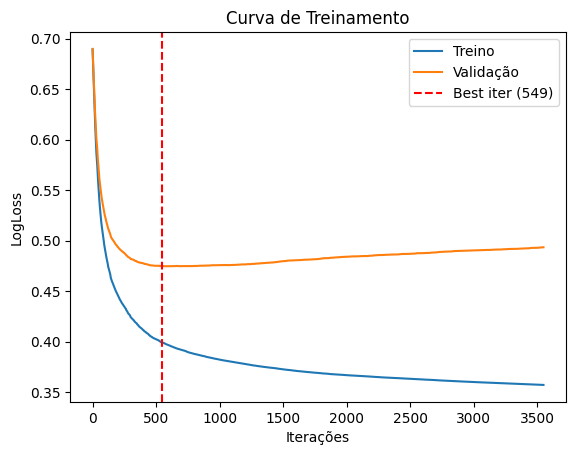

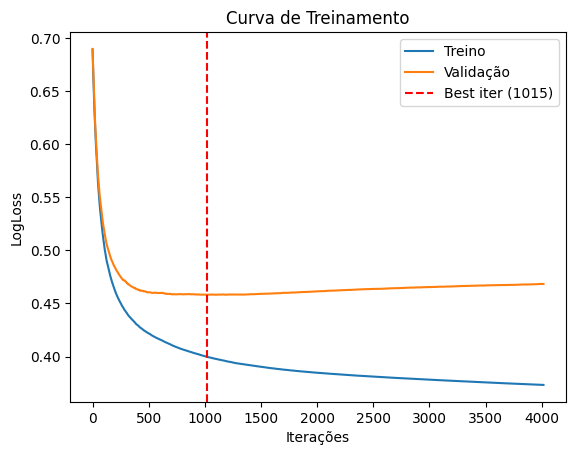

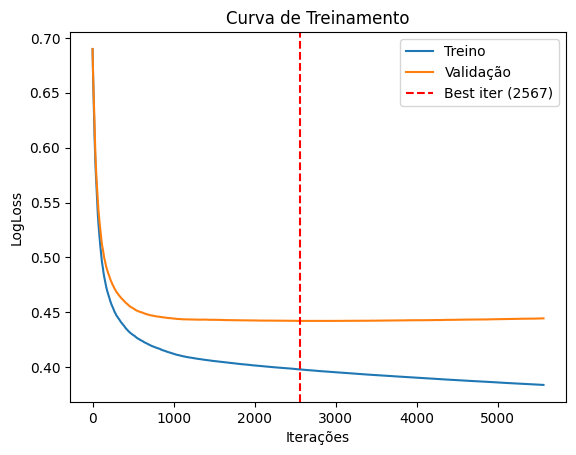

,AUC,KS
Treino,84.67,53.01


In [12]:
lista_modelos = []
for i in range(0, 10):
    df_t = df_train.sample(frac = 0.5, random_state = i)
    df_v = df_train[~df_train.index.isin(df_t.index)]
    X_t = df_t[features]
    y_t = df_t[alvo].astype(int)
    X_v = df_v[features]
    y_v = df_v[alvo].astype(int)

    if treinar_catboost:
        clf = CatBoostClassifier(
                            loss_function = 'Logloss',
                            use_best_model = True,
                            random_state = 42,
                            verbose = 0,

                            max_depth = 1, #Quando mais rasa as árvores menor (mais simples)
                            learning_rate = 0.01, #Quanto menor o learning_rate menor (menos incremento no modelo por iteração)
                            n_estimators = 10000 #Vamos forçar até o limite do overfitting
                            )
    else:
        clf = LGBMClassifier(
                            objective = 'binary',
                            boosting_type = 'gbdt',
                            force_row_wise = True,
                            random_state = 42,
                            n_jobs = -1,
                            verbose = -1,

                            max_depth = 1, #Quando mais rasa as árvores menor (mais simples)
                            learning_rate = 0.01, #Quanto menor o learning_rate menor (menos incremento no modelo por iteração)
                            n_estimators = 20000 #Vamos forçar até o limite do overfitting
                            )

    if usar_teste_treinamento:
        if treinar_catboost:
            clf.fit(
                    X, y,
                    eval_set = [(X, y), (df_teste[features], df_teste[alvo])],
                    early_stopping_rounds = 3000
                    )
        else:
            clf.fit(
                    X, y,
                    eval_set = [(X, y), (df_teste[features], df_teste[alvo])],
                    callbacks = [early_stopping(stopping_rounds = 3000, verbose = True)]
                    )
    else:
        if treinar_catboost:
            clf.fit(
                    X_t, y_t,
                    eval_set = [(X_t, y_t), (X_v, y_v)],
                    early_stopping_rounds = 3000
                    )
        else:
            clf.fit(
                    X_t, y_t,
                    eval_set = [(X_t, y_t), (X_v, y_v)],
                    callbacks = [early_stopping(stopping_rounds = 3000, verbose = True)]
                    )

    results = clf.evals_result_
    if treinar_catboost:
        plt.plot(results["validation_0"]["Logloss"], label="Treino")
        plt.plot(results["validation_1"]["Logloss"], label="Validação")
    else:
        try:
            plt.plot(results["training"]["binary_logloss"], label="Treino")
        except:
            plt.plot(results["valid_0"]["binary_logloss"], label="Treino")
        plt.plot(results["valid_1"]["binary_logloss"], label="Validação")
    plt.axvline(clf.best_iteration_, color="r", linestyle="--", label=f"Best iter ({clf.best_iteration_})")
    plt.xlabel("Iterações")
    plt.ylabel("LogLoss")
    plt.title("Curva de Treinamento")
    plt.legend()
    plt.show()

    lista_modelos.append(clf)

print('')

probs = np.mean([m.predict_proba(X)[:, 1] for m in lista_modelos], axis = 0)

df_metrics_treino = pd.DataFrame([[roc_auc_score(y, probs), ks_2samp(probs[y == 0], probs[y == 1]).statistic]],
                                 columns = ['AUC', 'KS'],
                                 index = ['Treino'])
display((df_metrics_treino*100).style.format(precision = 2))

In [13]:
results.keys()

dict_keys(['learn', 'validation_0', 'validation_1'])

# Avaliação no Conjunto de Teste

In [14]:
X_teste = df_teste[features]
y_teste = df_teste[alvo]

In [15]:
probs_teste = np.mean([m.predict_proba(X_teste)[:, 1] for m in lista_modelos], axis = 0)

df_metrics_teste = pd.DataFrame([[roc_auc_score(y_teste, probs_teste), ks_2samp(probs_teste[y_teste == 0], probs_teste[y_teste == 1]).statistic]],
                                columns = ['AUC', 'KS'],
                                index = ['Teste'])
display((df_metrics_teste*100).style.format(precision = 2))

,AUC,KS
Teste,84.14,53.58


# Análise em Subconjuntos

In [16]:
def analise_subconjunto(probs, y, mask, nome_subconjunto):
    df_metrics = pd.DataFrame([[roc_auc_score(y[mask], probs[mask]), ks_2samp(probs[(y == 0) & mask], probs[(y == 1) & mask]).statistic]],
                              columns = ['AUC', 'KS'],
                              index = [nome_subconjunto])
    return df_metrics

In [17]:
mask_partner_no = (df['Partner_No'] == 1).values
df_metrics_treino_solteiros = analise_subconjunto(probs, y, mask_partner_no, 'Treino_Solteiros')
display((df_metrics_treino_solteiros*100).style.format(precision = 2))

mask_partner_yes = (df['Partner_No'] == 0).values
df_metrics_treino_casados = analise_subconjunto(probs, y, mask_partner_yes, 'Treino_Casados')
display((df_metrics_treino_casados*100).style.format(precision = 2))

,AUC,KS
Treino_Solteiros,84.87,56.72


,AUC,KS
Treino_Casados,84.52,51.23


In [18]:
mask_partner_no = (df_teste['Partner_No'] == 1).values
df_metrics_teste_solteiros = analise_subconjunto(probs_teste, y_teste, mask_partner_no, 'Teste_Solteiros')
display((df_metrics_teste_solteiros*100).style.format(precision = 2))

mask_partner_yes = (df_teste['Partner_No'] == 0).values
df_metrics_teste_casados = analise_subconjunto(probs_teste, y_teste, mask_partner_yes, 'Teste_Casados')
display((df_metrics_teste_casados*100).style.format(precision = 2))

,AUC,KS
Teste_Solteiros,82.58,52.14


,AUC,KS
Teste_Casados,85.77,57.32


# Resumo Geral

In [19]:
df_resumo = pd.concat([df_metrics_treino, df_metrics_teste,
                       df_metrics_treino_solteiros, df_metrics_teste_solteiros,
                       df_metrics_treino_casados, df_metrics_teste_casados])

display((df_resumo.iloc[[0, 2, 4]]*100).style.format(precision = 2))

print('')

display((df_resumo.iloc[[1, 3, 5]]*100).style.format(precision = 2))

,AUC,KS
Treino,84.67,53.01
Treino_Solteiros,84.87,56.72
Treino_Casados,84.52,51.23


,AUC,KS
Teste,84.14,53.58
Teste_Solteiros,82.58,52.14
Teste_Casados,85.77,57.32


# Dataset Oculto

In [20]:
df_oculto = pd.read_csv('telco-customer-churn-oculto.zip', dtype = {'SeniorCitizen': str})
df_oculto[alvo] = df_oculto[alvo].map({'Yes': 1, 'No': 0})
df_oculto.loc[df_oculto['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_oculto['TotalCharges'] = df_oculto['TotalCharges'].astype(float)

for k,v in dict_dummies.items():
    for value in v:
        df_oculto[k + '_' + value] = (df_oculto[k] == value).astype(int)
    df_oculto.drop(k, axis = 1, inplace = True)
df_oculto.columns = [c.replace(' ', '_') for c in df.columns]

probs_oculto = np.mean([m.predict_proba(df_oculto[features])[:, 1] for m in lista_modelos], axis = 0)
y_oculto = df_oculto[alvo].astype(int)

df_metrics_oculto = pd.DataFrame([[roc_auc_score(y_oculto, probs_oculto), ks_2samp(probs_oculto[y_oculto == 0], probs_oculto[y_oculto == 1]).statistic]],
                                 columns = ['AUC', 'KS'],
                                 index = ['Oculto'])

mask_partner_no = (df_oculto['Partner_No'] == 1).values
df_metrics_oculto_solteiros = analise_subconjunto(probs_oculto, y_oculto, mask_partner_no, 'Oculto_Solteiros')

mask_partner_yes = (df_oculto['Partner_No'] == 0).values
df_metrics_oculto_casados = analise_subconjunto(probs_oculto, y_oculto, mask_partner_yes, 'Oculto_Casados')

df_resumo_oculto = pd.concat([df_metrics_oculto, df_metrics_oculto_solteiros, df_metrics_oculto_casados])
display((df_resumo_oculto*100).style.format(precision = 2))

,AUC,KS
Oculto,85.65,56.08
Oculto_Solteiros,83.67,51.91
Oculto_Casados,86.47,58.28


# Distribuição de Probabilidades

In [21]:
df['prob'] = probs
df_teste['prob'] = probs_teste
df_oculto['prob'] = probs_oculto
df_geral = pd.concat([df, df_teste, df_oculto])

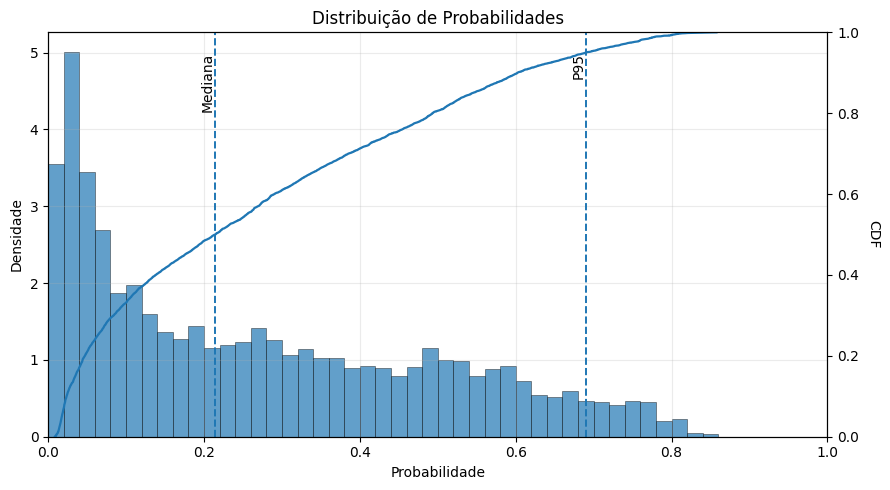

In [22]:
# 1) série limpa (probabilidades costumam estar em [0,1])
p = df_geral['prob'].dropna().clip(0, 1).values

# 2) bins fixos (iguais) — bons para comparar e evitar "denteado"
bins = np.linspace(0, 1, 51)  # 50 bins de 0.02

fig, ax = plt.subplots(figsize=(9, 5))

# 3) histograma como densidade (forma fica mais clara em desbalanceios)
ax.hist(p, bins=bins, density=True, alpha=0.7, edgecolor='k', linewidth=0.4)

# 4) (opcional) CDF no eixo secundário — ótimo para escolher cortes
ax2 = ax.twinx()
p_sorted = np.sort(p)
cdf = np.arange(1, len(p_sorted)+1) / len(p_sorted)
ax2.plot(p_sorted, cdf, linewidth=1.6)
ax2.set_ylabel('CDF', rotation=270, labelpad=15)
ax2.set_ylim(0, 1)

# 5) linhas-guia: mediana e P95 (ajuste quantis conforme seu uso)
q50, q95 = np.quantile(p, [0.50, 0.95])
for q, lab in [(q50, 'Mediana'), (q95, 'P95')]:
    ax.axvline(q, ls='--', lw=1.4)
    ax.text(q, ax.get_ylim()[1]*0.95, lab, rotation=90, va='top', ha='right')

ax.set_title('Distribuição de Probabilidades')
ax.set_xlabel('Probabilidade')
ax.set_ylabel('Densidade')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

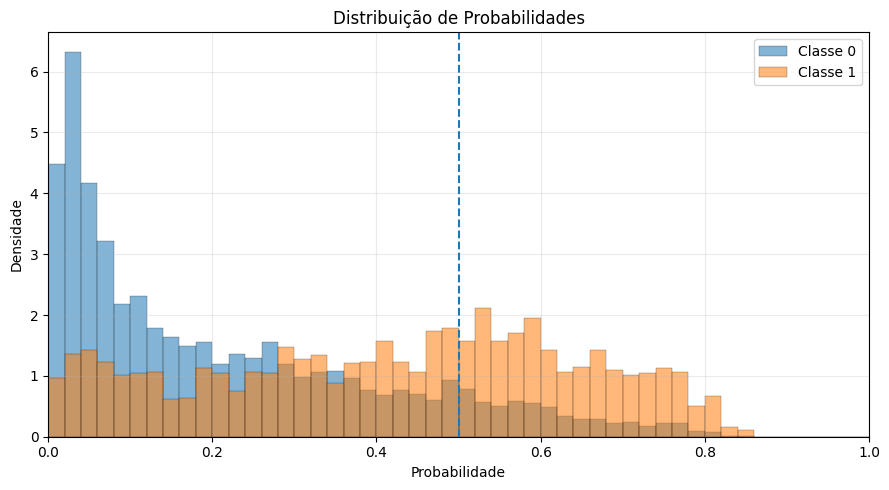

In [23]:
# separa as séries
neg = df_geral.loc[df_geral[alvo] == 0, 'prob'].values
pos = df_geral.loc[df_geral[alvo] == 1, 'prob'].values

# mesmos bins p/ ambos (probabilidades em [0,1])
bins = np.linspace(0, 1, 51)  # 50 bins iguais

fig, ax = plt.subplots(figsize=(9,5))

ax.hist(neg, bins=bins, density=True, alpha=0.55, edgecolor='k', linewidth=0.3,
        label='Classe 0')
ax.hist(pos, bins=bins, density=True, alpha=0.55, edgecolor='k', linewidth=0.3,
        label='Classe 1')

# (opcional) linha de threshold
thr = 0.5
ax.axvline(thr, linestyle='--', linewidth=1.5)

ax.set_title('Distribuição de Probabilidades')
ax.set_xlabel('Probabilidade')
ax.set_ylabel('Densidade')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()